In [261]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sympy import ntheory
from numpy.linalg import matrix_power
import time
import matplotlib
from sympy.geometry import Point, Circle

In [262]:
tolerance = 1e-6

In [263]:
def getOrtho(circ1,circ2):
    r1,x1 = circ1 
    r2,x2 = circ2
    if abs(x1-x2)<tolerance:
        return (np.inf, (x1+x2)/2)
    c1 = x1**2-r1**2
    c2 = x2**2-r2**2
    h = (c1-c2)/(2*(x2-x1))
    x3 = -h
    r3 = math.sqrt(h**2+2*x1*h+c1)
    return (r3, x3)

In [264]:
def getShear(pants1,pants2, gamma,s = 5):
    circlesList, pbar,p = pantsShear(pants1,pants2,gamma,s)
    circ1 = getOrtho((abs(circlesList[2][0]),circlesList[2][1]),(abs(circlesList[3][0]),circlesList[3][1]))
    circ2 = getOrtho((abs(circlesList[3][0]),circlesList[3][1]),(abs(circlesList[4][0]),circlesList[4][1]))
    circ3 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[1][0]),circlesList[1][1]))
    circ4 = getOrtho((abs(circlesList[0][0]),circlesList[0][1]),(abs(circlesList[5][0]),circlesList[5][1]))
    if not pIsIn(p, toInterval(circ1)):
        circ1 = (-circ1[0],circ1[1])
    if not pIsIn(p,toInterval(circ2)):
        circ2 = (-circ2[0],circ2[1])
    if not pIsIn(pbar, toInterval(circ3)):
        circ3 = (-circ3[0],circ3[1])
    if not pIsIn(pbar,toInterval(circ4)):
        circ4 = (-circ4[0],circ4[1])
    sign_1 = 1
    sign_2 = 1
    if intIsIn(toInterval(circ1), toInterval(circ2)):
        sign_1 = -1
    if intIsIn(toInterval(circ3), toInterval(circ4)):
        sign_2 = -1
    radiusCenterPlotter(circlesList+[circ1,circ2]+[circ3,circ4],s)
    radiusCenterPlotter2(circlesList+[circ1,circ2]+[circ3,circ4],s)
    return (-1*sign_1*getDist(circ1,circ2), sign_2*getDist(circ3,circ4))

In [265]:
def toInterval(circ): #we implicitly assume that we can never have trivial intervals of (x,x) = emptyset
    r,x = circ
    if r==np.inf:
        return (x,np.inf)
    elif r==np.NINF:
        return (np.NINF,x)
    else:
        return (x-r, x+r)

In [266]:
def getDist(circ1,circ2):
    circ1,circ2 = getInv(circ1), getInv(circ2)
    t1,u1,v1 = circ1
    t2,u2,v2 = circ2
    a = (t1*u2/2+t2*u1/2-v1*v2)
    return np.arccosh(abs(a))

In [267]:
def getInv(circ):
    r,x = circ
    if r == np.inf or r == np.NINF:
        return (2*x,0,1)
    return ((x**2-r**2)/r, 1/r, x/r)

In [268]:
def InvToNormal(circ,N):
    t,u,v = circ
    if abs(u)<tolerance:
        return (np.inf,t/2)
    else:
        r = 1/u
        x = r*v
        return (r,x)

In [269]:
def pIsIn(p,interval): # open intervals
    if interval[0] < interval[1]:
        return interval[0] < p and p < interval[1]
    else:
        return interval[0] < p or p < interval[1]

In [270]:
def intIsIn(int1, int2): # returns whether interval 1 contains interval 2 (i.e. True = "1 contains 2")
    if int1[0] < int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    elif int1[0] > int1[1] and int2[0] < int2[1]:
        return int1[0] <= int2[0] or int2[1] <= int1[1]
    elif int1[0] > int1[1] and int2[0] > int2[1]:
        return int1[0] <= int2[0] and int1[1] >= int2[1]
    else:
        return False

In [271]:
def act(M,x):
    return (M[0,0]*x+M[0,1])/(M[1,0]*x+M[1,1])

In [272]:
def pairToFrac(s1, s2):
    return minPermutation(recover(list(s1) + [1] + list(inv(s2)) + [1]))

In [273]:
def pantsShear(pants1, pants2, y,s = 5): # y is given in minimal form, without any 0's 
    s0,s1,s2 = pants1
    pants1Arr = []
    
    pants1Arr.append(pairToFrac(s1,s2))
    pants1Arr.append(pairToFrac(s2,s0))
    pants1Arr.append(pairToFrac(s0,s1))
    #pair to frac here sends extra R's at the front to the end, so it makes sense to compare to y later.
    
    i = -1
    for l in range(3):
        if pants1Arr[l] == y:
            i = l
    
    pants1_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants1_new = pants1_new[i:] + pants1_new[:i]
    pants1  = pants1[i:] + pants1[:i]
    
    #the above puts the cuff that matches to y into the first slot of the array
    #example: if i = 1, then pants1_new = [gamma1,gamma2,gamma0], and pants1 = [s1,s2,s0]
    
    s0,s1,s2 = pants2
    
    pants2Arr = []
    
    pants2Arr.append(pairToFrac(s1,s2))
    pants2Arr.append(pairToFrac(s2,s0))
    pants2Arr.append(pairToFrac(s0,s1))
    
    for l in range(3):
        if minPermutation(pants2Arr[l][::-1]) == y:
            i = l
    
    pants2_new = [pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)]
    pants2_new = pants2_new[i:] + pants2_new[:i]
    pants2 = pants2[i:] + pants2[:i]
    #the above puts the cuff that matches to the inverse of y into the first slot of the array
    
    gamma_1 = pants1_new[0]
    gamma_2 = pants2_new[0]
    
    #the above are the two geodesics we want to match
    A_1 = np.eye(2)
    A_2 = np.eye(2)
    if gamma_1[0]==0:
        A_1 = np.linalg.inv(np.array([[0,1],[1,-gamma_1[1]]]) @ np.array([[0,1],[1,0]]))
        gamma_1[-1]+=gamma_1[1]
        gamma_1 = gamma_1[2:]
    
    #the above occurs when the start of the geo cutting sequence was an R and we then put a 0 in the cont frac
    #to represent L^0
    #we then store A_1 as the matrix that acts on the continued fraction by concatenating gamma_1[1] to the front
    #next, we add gamma_1[1] to the last entry as that is how 0 works for continued fractions, and then take away entries
        
    
    if gamma_2[0]==0:
        A_2 = np.array([[0,1],[1,-gamma_2[1]]]) @ np.array([[0,1],[1,0]])
        gamma_2[-1]+=gamma_2[1]
        gamma_2 = gamma_2[2:]
        
    #the above stored matrix action on the cont frac is: delete the 0, then delete gamma_2[1] (really, rotate by 2 slots)
    
    gamma_2 = gamma_2[::-1]
    l = len(gamma_1)
    #reverse gamma_2 so we can compare it to gamma_1
    k = -1
    for i in range(0,l,2):
        if (gamma_2[i:]+gamma_2[:i]) == gamma_1:
            k = i
    #the above marks which even permutation we need to take to match back to gamma_1
    mat = np.array([[0,1],[-1,0]])

    for i in range(k):
        mat = np.matmul(np.array([[0,1],[1,-gamma_2[i]]]), mat)

    #the original matrix is -1/z action that reverses the order of the cont frac of conj(z)
    #the other multiplications take away entries now from the back of gamma_2
        
    B = np.array([[0,1],[-1,1]])
    
    #the above matrix permutes 0,1,infty cyclically. represented by: 1/(1-z)
    
    T = np.array([[1,1],[0,1]])
    
    #the above adds 1 to the cont frac
    
    T_inv = np.array([[1,-1],[0,1]])
    
    #the above subtracts 1 from the cont frac
    
    M = ((((((B @ T) @ A_1) @ mat) @ A_2) @ T_inv) @ matrix_power(B, 2))
    pants2_in_plane = pantsInPlane(pants2)
    min_max = [(x-r,x+r) for (r,x) in pants2_in_plane]
    pants2_in_plane = [(act(M, mini),act(M,maxi)) for (mini,maxi) in min_max]
    pants2_in_plane = [((x_max-x_min)/2,(x_max+x_min)/2) for (x_min,x_max) in pants2_in_plane]
    pants1_in_plane  = pantsInPlane(pants1)
    pbar = pants1_in_plane[0][1] - pants1_in_plane[0][0]
    p = pants1_in_plane[0][1] + pants1_in_plane[0][0]
    radiusCenterPlotter(pants1_in_plane, s)
    radiusCenterPlotter2(pants1_in_plane, s)
    radiusCenterPlotter(pants2_in_plane, s)
    radiusCenterPlotter2(pants2_in_plane, s)
    radiusCenterPlotter(pants1_in_plane + pants2_in_plane, s)
    radiusCenterPlotter2(pants1_in_plane + pants2_in_plane, s)
    return (pants1_in_plane + pants2_in_plane, pbar, p)

In [274]:
#this thing will brute force compute the shears of a list of pants given by a range of traces
def bruteShearsOnTraceRange(tmin, tmax):
    shear_list = []
    pre_pants_list = list(pantsInTraceRange(tmin,tmax))
    pos_geo_list = pantsToGeodesics(pre_pants_list) #remember to import pantsToGeodesics. remember the geos here are minimal
    pants_list = list(pantsInTraceRange2(tmin,tmax))
    #also need to fix the rep of these pants to include 0s... the functions called here get rid of 0s
    for geo in pos_geo_list:
        inv_geo = geo[::-1]
        list_of_pants_with_cuff = []
        list_of_pants_with_inv_cuff = []
        length = len(geo)
        for i in range(0,length,2):
            list_of_pants_with_cuff + pantsInTraceRangeWithCuff2(tmin, tmax, geo[i:] + geo[i:])
        for i in range(0,length,2):
            list_of_pants_with_inv_cuff + pantsInTraceRangeWithCuff2(tmin, tmax, inv_geo[i:] + inv_geo[i:])
        for pants in list_of_pants_with_cuff:
            for inv_pants in list_of_pants_with_inv_cuff:
                shear_list.append(getShear(pants,inv_pants,geo)) #still need to fix rep of pants
    return shear_list

#things to import and convert:
#pantsInTraceRange, pantsToGeodesics, pantsInTraceRangeWithCuff. look at listSplit-Copy1

In [275]:
def isOdd(sequence):
    return len(sequence) % 2

In [276]:
def rotl(x, k):
    return x[k:] + x[:k]

In [277]:
def permutationsOf(sequence):
    return list(permutationsOfGen(sequence))

In [278]:
def permutationsOfGen(sequence):
    for n in range(0, len(sequence), 1 if isOdd(sequence) else 2):
        yield rotl(sequence, n)

In [279]:
def minPermutation(sequence):
    return min(permutationsOfGen(sequence))

In [280]:
def inv(lr_sequence):
    return tuple((np.array(lr_sequence[::-1]) - 1) ** 2)

In [281]:
def pairToFrac2(s1,s2):
    return recover2(list(s1) + [1] + list(inv(s2)) + [1])

In [282]:
def recover(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):    #this is the line where we lump things
        output[-1] += output[0]
        output = output[1:]
    return output

def recover2(ls):
    output = []
    i = 0
    while i < len(ls):
        counter = 1
        while (i < len(ls) - 1 and ls[i] == ls[i + 1]):
            i += 1
            counter += 1
        i += 1
        output.append(counter)
    if isOdd(output):  
        output = [0]+output
    return output

In [283]:
#this cell for graphing matrices from continued fractions
def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(int)

def npCfReduce(cf): #works on fully periodic continued fractions
    mat = cfToMat(cf)
    return (mat[0,0]-mat[1,1] + math.sqrt(mat[0,0]**2+mat[1,1]**2+2*mat[1,0]*mat[0,1]-2))/(2*mat[1,0])

def geodesicInfoFromMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    tr = np.trace(M)
    if abs(tr) <= 2:
        raise ValueError('Matrix should have trace > 2')
    if tr < 0:
        M = -M
        tr = -tr
    length = 2*math.log(tr/2+math.sqrt((tr/2)**2-1))
    eig = math.exp(1)**(length/2)
    a = M.item(0,0)
    b = M.item(0,1)
    c = M.item(1,0)
    d = M.item(1,1)
    if c > 0:
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[eig-d,1/eig-d],[c,c]])
    else: 
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[-eig+d,1/eig-d],[-c,c]])
    visPt = (eig-d)/c
    newA = eigMat.item(0,0)
    newB = eigMat.item(0,1)
    newC = eigMat.item(1,0)
    newD = eigMat.item(1,1)
    visPtConj = (a - d - math.sqrt(tr**2 - 4))/(2*c)
    z = (newA*1j+newB)/(newC*1j+newD)
    zeta = 1j/(newC*1j+newD)**2
    return (length,eig,eigMat,visPt,visPtConj,z,zeta)

def plotMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    trace = np.trace(M)
    visPt = geodesicInfoFromMatrix(M)[3]
    visPtConj = geodesicInfoFromMatrix(M)[4]
    radius = (visPt - visPtConj)/2
    center = (visPt + visPtConj)/2
    circle = (radius, center)
    
    fig, ax = plt.subplots()
    minimum = -1 + (circle[1]-abs(circle[0]))
    maximum = 1 + (circle[1]+abs(circle[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(abs(circle[0])+1))
    
    circle1 = plt.Circle((circle[1],0), abs(circle[0]), fill = False, color = 'r')
    
    if circle[0]>0:
        plt.plot(circle[1], abs(circle[0]), '>', color=  'r')
    else:
        plt.plot(circle[1], abs(circle[0]), '<', color=  'r')
    
    ax.add_artist(circle1)
    ax.set_aspect('equal', adjustable='box')

In [296]:
def circlePoints(circ, N = 100):
    r,x = circ
    x_values,y_values = [],[]
    for i in range(N+1):
        curr_x = x+r*math.cos(pi*i/N)
        curr_y = r*math.sin(pi*i/N)
        x_values.append(curr_x)
        y_values.append(curr_y)
    return (x_values,y_values)

In [285]:
def h(point):
    xVals, yVals = point[0][0], point[0][1]
    output = [[],[]]
    for i in range(len(xVals)):
        x,y = xVals[i],yVals[i]
        a = x**2+(y+1)**2
        output[0].append((x**2+y**2-1)/a)
        output[1].append(-2*x/a)
    return output

In [286]:
def add_arrow(line, position=None, direction='right', size=15):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(abs(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle='simple'),
        size=size
    )

In [297]:
def radiusCenterPlotter2(circArray,s=5): #draw circle given an array of radii and centers
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    ax.set_xlim(-1,1.01)
    ax.set_ylim(-1.001,1.001)
    points = []
    plotCirc = plt.Circle((0,0), 1, fill = False)
    ax.add_artist(plotCirc)
    plotCirc = plt.Circle((1,0), math.log(s)/100, fill = True, color = 'black', clip_on = False)
    ax.add_artist(plotCirc)
    for circ in circles:
        points += [(circlePoints((abs(circ[0]), circ[1])),)]
    for i in range(len(circles)):
        circ = circles[i]
        x_values,y_values = h(points[i])
        line = plt.plot(x_values,y_values, 'black', linewidth = .3)[0]    
        if circ[0] < 0:
            add_arrow(line,position = x_values[len(x_values)//2], direction = 'right')
        else:
            add_arrow(line,position = x_values[len(x_values)//2], direction = 'left')
   
    for line in lines:
        points = [[(line[1],line[1],line[1]),(5,10,15)]]
        points = h(points)
        p = points
        points = (Point(p[0][0],p[1][0]), Point(p[0][1],p[1][1]), Point(p[0][2],p[1][2]))
        circ = Circle(points[0],points[1],points[2])
        r,center = circ.radius, (circ.center[0].evalf(),circ.center[1].evalf())
        plotCirc = plt.Circle((center[0],center[1]), abs(r), fill = False)
        ax.add_artist(plotCirc)
        #if line[0]< 0:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'right')
        #else:
        #    add_arrow(plotCirc,position = x_values[len(x_values)//2], direction = 'left')
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    ax.annotate(r"$\infty$",(1,0),(1+log(s)/50,-log(s)/55), size = 15*log(s))
    #plt.plot((1,0),color = 'black', marker = "o", markersize=10)
    plt.show()

In [298]:
def radiusCenterPlotter(circArray,s= 5): #draw circle given an array of radii and centers
    fig, ax = plt.subplots()
    fig.set_size_inches(s, s)
    circles = [circ for circ in circArray if circ[0]!=np.inf and circ[0]!=-np.inf]
    lines = [line for line in circArray if line[0]==np.inf or line[0]==-np.inf]
    minimum = min([circ[1]-abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    maximum = max([circ[1]+abs(circ[0]) for circ in circles]+[l[1] for l in lines])
    ranges = maximum-minimum
    maximum+=ranges/20
    minimum-=ranges/20
    maxY = max([abs(circ[0]) for circ in circles])
    maxY+=maxY/20
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(maxY))
    
    for circ in circles:
        plotCirc = plt.Circle((circ[1],0), abs(circ[0]), fill = False)
        if circ[0] > 0:
            plt.plot(circ[1], abs(circ[0]), '>')
        else:
            plt.plot(circ[1], abs(circ[0]), '<')
        ax.add_artist(plotCirc)
    for line in lines:
        plt.vlines(line[1], 0, float(maxY))
        if line[0]> 0:
            plt.plot(line[1],float(maxY/2), '^')
        else:
            plt.plot(line[1],float(maxY/2), 'v')
    ax.set_aspect('equal', adjustable='box')

In [299]:
def pantsInPlane(pants): #y0 is on top, y2 on left, y1 in default position (reduced position +1)
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = npCfReduce(y0)
    alpha_conj = -1/(npCfReduce(y0[::-1]))
    x_min = B(alpha_conj+1)
    x_max = B(alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y1)
    alpha_conj = -1/(npCfReduce(y1[::-1]))
    x_min = (alpha_conj+1)
    x_max = (alpha+1)
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y2)
    alpha_conj = -1/(npCfReduce(y2[::-1]))
    x_min = B(B(alpha_conj+1))
    x_max = B(B(alpha+1))
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    return circles

In [300]:
def plotPants(pants): # y0 is red, y1 is green, y2 is blue
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')
    s0,s1,s2 = pants
    print('red: ' + str(pairToFrac2(s0,s1)))
    print('green: ' + str(pairToFrac2(s1,s2)))
    print('blue: ' + str(pairToFrac2(s2,s0)))

In [301]:
def pantsInPlane2(pants):
    circles = []
    s0,s1,s2 = pants
    y2 = pairToFrac2(s0,s1)
    y0 = pairToFrac2(s1,s2)
    y1 = pairToFrac2(s2,s0)
    B = lambda x : 1/(1-x)
    
    alpha = npCfReduce(y0)
    alpha_conj = -1/(npCfReduce(y0[::-1]))
    x_min = alpha_conj
    x_max = alpha
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y1)
    alpha_conj = -1/(npCfReduce(y1[::-1]))
    x_min = alpha_conj
    x_max = alpha
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    
    alpha = npCfReduce(y2)
    alpha_conj = -1/(npCfReduce(y2[::-1]))
    x_min = alpha_conj
    x_max = alpha
    r = (x_max-x_min)/2
    x = (x_min+x_max)/2
    circles.append((r,x))
    return circles
    
def plotPants2(pants):
    fig, ax = plt.subplots()
    
    circ1, circ2, circ3 = pantsInPlane2(pants)
    minimum = -1+min(circ1[1]-abs(circ1[0]), circ2[1]-abs(circ2[0]), circ3[1]-abs(circ3[0]))
    maximum = 1+max(circ1[1]+abs(circ1[0]), circ2[1]+abs(circ2[0]), circ3[1]+abs(circ3[0]))
    ax.set_xlim(float(minimum),float(maximum))
    ax.set_ylim(0, float(max(abs(circ1[0]), abs(circ2[0]), abs(circ3[0]))+1))
    
    circle1 = plt.Circle((circ1[1],0), abs(circ1[0]), fill = False, color = 'r')
    circle2 = plt.Circle((circ2[1],0), abs(circ2[0]), fill = False, color = 'g')
    circle3 = plt.Circle((circ3[1],0), abs(circ3[0]), fill = False, color = 'b')
    
    if circ1[0]>0:
        plt.plot(circ1[1], abs(circ1[0]), '>', color=  'r')
    else:
        plt.plot(circ1[1], abs(circ1[0]), '<', color=  'r')
    if circ2[0]>0:
        plt.plot(circ2[1], abs(circ2[0]), '>', color=  'g')
    else:
        plt.plot(circ2[1], abs(circ2[0]), '<', color=  'g')
    if circ3[0]>0:
        plt.plot(circ3[1], abs(circ3[0]), '>', color=  'b')
    else:
        plt.plot(circ3[1], abs(circ3[0]), '<', color=  'b')
        
    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.set_aspect('equal', adjustable='box')

In [292]:
def geos(pants):
    s0,s1,s2 = pants
    return pairToFrac2(s1,s2),pairToFrac2(s2,s0),pairToFrac2(s0,s1)

def minGeos(pants):
    s0,s1,s2 = pants
    return pairToFrac(s1,s2),pairToFrac(s2,s0),pairToFrac(s0,s1)

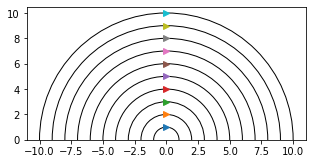

In [293]:
radiusCenterPlotter([(1,0),(2,0),(3,0),(4,0),(5,0),(6,0), (7,0), (8,0),(9,0),(10,0)])

In [294]:
pantsInPlane(([1,1,1,0], [0,1,0,1,1], [0,0,1,0]))

[(-2.234519989790892, 1.5882352941176474),
 (1.681203818991539, 1.9090909090909092),
 (0.42513200020475705, -0.20689655172413798)]

NameError: name 'cos' is not defined

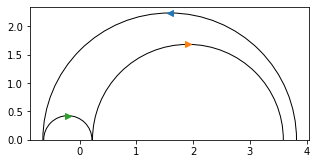

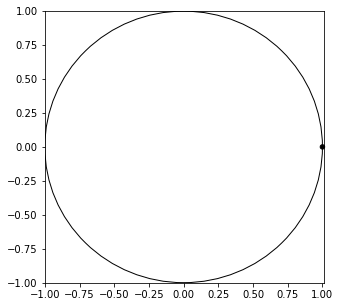

In [295]:
getShear(([1,1,1,0], [0,1,0,1,1], [0,0,1,0]),([0,0,0],[1,0,1,1,1,1],[0,0,1,1,1]),[1,1,1,4,1,3])

In [147]:
getShear(([0,0,1,0],[0,1,0],[0,1,1,0,1,1,1]),([0,1,0],[0,0,1,0,0,1,1],[1,1,0,0]),[1, 1, 1, 1, 3, 1, 2, 2])

(-5.0740173050691055, -5.074017305548428)

In [148]:
getShear(([1,1,1,1,1,1,0,1,0], [0,1,1,1,1], [1,0,1,0,1,1]),([0,0,1,1,1],[1,0,1,1,1,1,0,1,0,0],[1,0,0,1,1]),[1,1,1,4,1,1,6,2])

(3.437873616958345, 3.4378736169583233)

In [180]:
getShear(([1,1,1,1,1,1,0,1,0], [0,1,1,1,1], [1,0,1,0,1,1]),([1,0,0,0,0,0],[1,0,0,1,1],[0,0,0,0,1,0,1,0,0]),[1,1,1,4,1,1,6,2])

(-5.444462912236995, -5.444462901161734)

In [181]:
getShear(((0,), (0, 1), (1, 0, 0)), ((0, 0), (1,), (1, 1, 0, 1, 1)), (1, 1, 1, 2), s= 5)

(0.6102897852195379, 0.6102897852195363)

In [190]:
getShear(([1,1,1,1,1,1,0,1,0], [0,1,1,1,1], [1,0,1,0,1,1]),([1,0,0,0,0,0],[1,0,0,1,1],[0,0,0,0,1,0,1,0,0]),[1,1,1,4,1,1,6,2]) 

0.2543506622314453 0.0001232624053955078 0.004377126693725586 8.58306884765625e-05 0.21970605850219727 1.9788742065429688e-05


(-5.444462912236995, -5.444462901161734)